In [1]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018")

#print("Path to dataset files:", path)


## KASUS KLASIFIKASI PENERBANGAN CANCEL

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col,sum
import pyspark.sql.types as T 
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
spark = SparkSession.builder.config("spark.executor.memory","4g").config("spark.driver.memory", "4g").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [6]:
file_names_range = list(range(2013, 2018))
file_paths = [fr'C:\Users\khansa resqi\.cache\kagglehub\datasets\yuanyuwendymu\airline-delay-and-cancellation-data-2009-2018\versions\1\{file}.csv' for file in file_names_range]
#file_paths = [fr'C:\Users\Farhan\.cache\kagglehub\datasets\yuanyuwendymu\airline-delay-and-cancellation-data-2009-2018\versions\1\{file}.csv' for file in file_names_range]

In [7]:
schema = T.StructType([
    T.StructField("FL_DATE", T.TimestampType(), nullable=True),
    T.StructField("OP_CARRIER", T.StringType(), nullable=True),
    T.StructField("OP_CARRIER_FL_NUM", T.IntegerType(), nullable=True),
    T.StructField("ORIGIN", T.StringType(), nullable=True),
    T.StructField("DEST", T.StringType(), nullable=True),
    T.StructField("CRS_DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_DELAY", T.DoubleType(), nullable=True),
    T.StructField("TAXI_OUT", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_OFF", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_ON", T.DoubleType(), nullable=True),
    T.StructField("TAXI_IN", T.DoubleType(), nullable=True),
    T.StructField("CRS_ARR_TIME", T.DoubleType(), nullable=True),
    T.StructField("ARR_TIME",T.DoubleType(), nullable=True),
    T.StructField("ARR_DELAY", T.DoubleType(), nullable=True),
    T.StructField("CANCELLED", T.DoubleType(), nullable=True),
    T.StructField("CANCELLATION_CODE", T.StringType(), nullable=True),
    T.StructField("DIVERTED", T.DoubleType(), nullable=True),
    T.StructField("CRS_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("ACTUAL_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("AIR_TIME", T.DoubleType(), nullable=True),
    T.StructField("DISTANCE", T.DoubleType(), nullable=True),
    T.StructField("CARRIER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("WEATHER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("NAS_DELAY", T.DoubleType(), nullable=True),
    T.StructField("SECURITY_DELAY", T.DoubleType(), nullable=True),
    T.StructField("LATE_AIRCRAFT_DELAY", T.DoubleType(), nullable=True),
    T.StructField("Unnamed: 27", T.StringType(), nullable=True)
])

In [8]:
df = spark.read.schema(schema).format("csv").option("header", "true").load(file_paths)

In [9]:
df.limit(5).toPandas()  

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2013-01-01,VX,108,LAX,IAD,700.0,700.0,0.0,8.0,708.0,...,285.0,258.0,243.0,2288.0,NaN,NaN,NaN,NaN,NaN,None
1,2013-01-01,VX,114,LAX,IAD,2205.0,2204.0,-1.0,12.0,2216.0,...,280.0,272.0,247.0,2288.0,NaN,NaN,NaN,NaN,NaN,None
2,2013-01-01,VX,11,JFK,SFO,730.0,729.0,-1.0,18.0,747.0,...,405.0,380.0,356.0,2586.0,NaN,NaN,NaN,NaN,NaN,None
3,2013-01-01,VX,121,PHL,LAX,700.0,700.0,0.0,14.0,714.0,...,360.0,374.0,352.0,2402.0,NaN,NaN,NaN,NaN,NaN,None
4,2013-01-01,VX,124,LAX,PHL,1100.0,1104.0,4.0,12.0,1116.0,...,315.0,273.0,252.0,2402.0,NaN,NaN,NaN,NaN,NaN,None


In [10]:
#Tipe data tiap kolom
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

In [25]:
# Hitung jumlah null values di setiap kolom
null_counts = df.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df.columns])
null_counts.show()


+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|      0| 

In [26]:
#Drop kolom yang tidak diperlukan berdasarkan jumlah null values
classify_df = df.drop("Unnamed: 27", 
                        "CARRIER_DELAY", 
                        "WEATHER_DELAY",
                        "NAS_DELAY",
                        "SECURITY_DELAY",
                        "LATE_AIRCRAFT_DELAY",
                        "DEP_TIME",
                        "DEP_DELAY",
                        "TAXI_OUT",
                        "WHEELS_OFF",
                        "CANCELLATION_CODE",
                        "WHEELS_ON",
                        "TAXI_IN",
                        "ARR_TIME",
                        "ARR_DELAY",
                        "ACTUAL_ELAPSED_TIME", 
                        "AIR_TIME")

In [27]:
#Ubah tipe data kolom FL_DATE menjadi timestamp dengan jumlah detik 
classify_df = classify_df.withColumn("FL_DATE", F.unix_timestamp("FL_DATE"))

In [28]:
classify_df.limit(5).toPandas()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
0,1356973200,VX,108,LAX,IAD,700.0,1445.0,0.0,0.0,285.0,2288.0
1,1356973200,VX,114,LAX,IAD,2205.0,545.0,0.0,0.0,280.0,2288.0
2,1356973200,VX,11,JFK,SFO,730.0,1115.0,0.0,0.0,405.0,2586.0
3,1356973200,VX,121,PHL,LAX,700.0,1000.0,0.0,0.0,360.0,2402.0
4,1356973200,VX,124,LAX,PHL,1100.0,1915.0,0.0,0.0,315.0,2402.0


In [29]:
# hitung jumlah null values di setiap kolom setelah drop kolom
null_counts = classify_df.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in classify_df.columns])

null_counts.show()

+-------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|DISTANCE|
+-------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+
|      0|         0|                0|     0|   0|           0|           0|        0|       0|              30|       0|
+-------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+



In [30]:
classify_df.columns

['FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'DISTANCE']

In [31]:
carriers_flight_count_df = classify_df.groupBy(F.col('OP_CARRIER')).count().orderBy(F.col('count').desc())
top_10 = carriers_flight_count_df.limit(10).toPandas()
top_10 = top_10.rename(columns={'OP_CARRIER':'Carrier'})
top_10

,Carrier,count
0,WN,6196080
1,DL,4277232
2,AA,3612415
3,OO,3140202
4,EV,2837225
5,UA,2644597
6,B6,1339645
7,MQ,1127198
8,US,1025753
9,AS,849869


In [32]:

import altair as alt
chart = alt.Chart(top_10).mark_arc(outerRadius=260, innerRadius=75).encode(
    theta = alt.Theta(field="count", type="quantitative", stack=True),
    color = alt.Color('Carrier:N', scale=alt.Scale(scheme='category20'), legend=None),
).properties(
    title='Top 10 Carriers by amount of flights',
    width=600,
    height=300
)

pie = chart.mark_arc(outerRadius=350)
value_text = pie.mark_text(radius=300, size=15).encode(text=alt.Text('count:Q'))

pie2 = chart.mark_arc(outerRadius=250)
text = pie2.mark_text(radius=200, size=15).encode(
    text=alt.Text('Carrier:N'), 
    color=alt.value("#000000")
)

(chart + text + value_text).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=18
)

alt.LayerChart(...)

In [55]:
carriers_flight_count_df = df.filter(F.col('CANCELLATION_CODE').isNotNull()).groupBy(F.col('CANCELLATION_CODE')).count()
cancellation_reasons = carriers_flight_count_df.toPandas()
cancellation_reasons

,CANCELLATION_CODE,count
0,B,233377
1,D,559
2,C,93047
3,A,134451


In [56]:
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'A'] = 'By carrier'
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'B'] = 'Due to weather'
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'C'] = 'By national air system'
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'D'] = 'For security'
cancellation_reasons = cancellation_reasons.rename(columns={'CANCELLATION_CODE':'Reason'})

In [57]:
cancellation_reasons

,Reason,count
0,Due to weather,233377
1,For security,559
2,By national air system,93047
3,By carrier,134451


In [58]:
chart = alt.Chart(cancellation_reasons).mark_arc(outerRadius=180, innerRadius=50).encode(
    theta = alt.Theta(field="count", type="quantitative", stack=True),
    color = alt.Color('Reason:N', scale=alt.Scale(scheme='category20'), legend=None),
).properties(
    title='Reasons for flight cancellations',
    width=600,
    height=300
)

pie = chart.mark_arc(outerRadius=250)
value_text = pie.mark_text(radius=220, size=15).encode(text=alt.Text('count:Q'))

pie2 = chart.mark_arc(outerRadius=150)
text = pie2.mark_text(radius=120, size=12).encode(
    text=alt.Text('Reason:N'), 
    color=alt.value("#000000")
)

(chart + text + value_text).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=18
)

alt.LayerChart(...)

In [59]:
print(classify_df.head())

Row(FL_DATE=1356973200, OP_CARRIER='VX', OP_CARRIER_FL_NUM=108, ORIGIN='LAX', DEST='IAD', CRS_DEP_TIME=700.0, CRS_ARR_TIME=1445.0, CANCELLED=0.0, DIVERTED=0.0, CRS_ELAPSED_TIME=285.0, DISTANCE=2288.0)


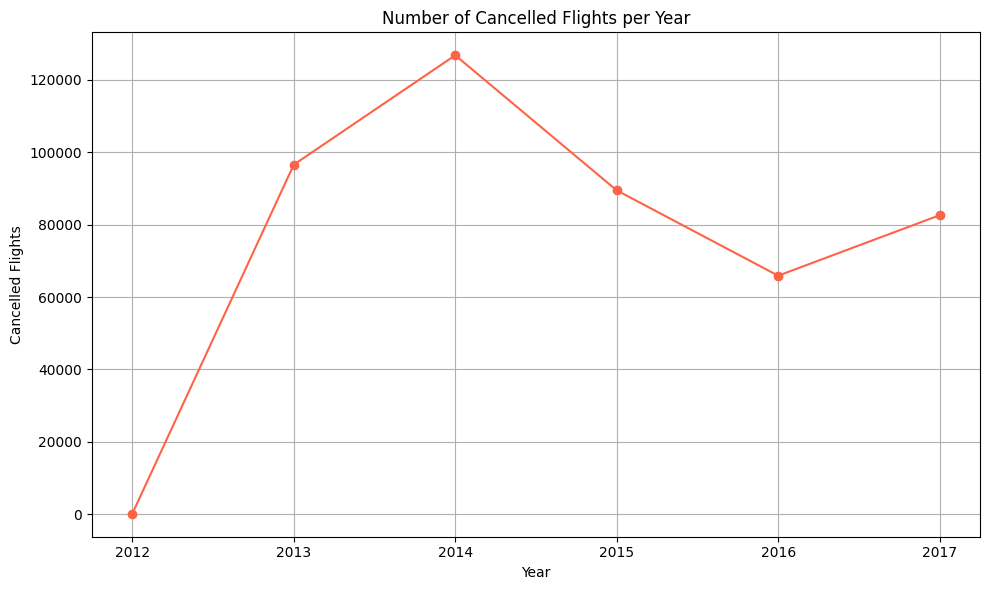

In [64]:
# Ambil FL_DATE dan CANCELLED
pdf = classify_df.select('FL_DATE', 'CANCELLED').toPandas()

# Ubah FL_DATE menjadi datetime dari timestamp (dalam detik)
pdf['FL_DATE'] = pd.to_datetime(pdf['FL_DATE'], unit='s')

# Ekstrak tahun
pdf['YEAR'] = pdf['FL_DATE'].dt.year

# Hitung jumlah pembatalan per tahun
cancelled_per_year = pdf[pdf['CANCELLED'] == 1].groupby('YEAR').size()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cancelled_per_year.index, cancelled_per_year.values, marker='o', color='tomato')
plt.xlabel('Year')
plt.ylabel('Cancelled Flights')
plt.title('Number of Cancelled Flights per Year')
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
print(pdf['FL_DATE'].min())
print(pdf['FL_DATE'].max())

2012-12-31 17:00:00
2017-12-30 17:00:00


In [66]:
print(pdf.head())

              FL_DATE  CANCELLED  YEAR
0 2012-12-31 17:00:00        0.0  2012
1 2012-12-31 17:00:00        0.0  2012
2 2012-12-31 17:00:00        0.0  2012
3 2012-12-31 17:00:00        0.0  2012
4 2012-12-31 17:00:00        0.0  2012


Jumlah data total: 29300651

Jumlah data per label:
CANCELLED
0.0    28839217
1.0      461434
Name: count, dtype: int64

Persentase per label:
CANCELLED
0.0    98.425175
1.0     1.574825
Name: count, dtype: float64


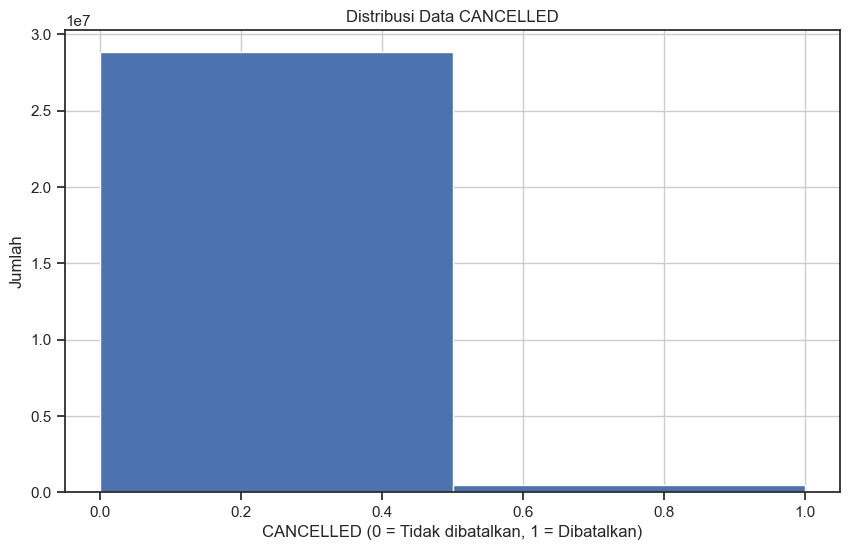

In [73]:
pdf = classify_df.select('CANCELLED').toPandas()

# Tampilkan jumlah data total
print("Jumlah data total:", len(pdf))

# Tampilkan jumlah data untuk tiap label
label_counts = pdf['CANCELLED'].value_counts()
print("\nJumlah data per label:")
print(label_counts)

# Kalau mau lihat persentasenya juga:
print("\nPersentase per label:")
print(label_counts / len(pdf) * 100)

# Plot histogram
pdf['CANCELLED'].hist(bins=2, figsize=(10, 6))  # bins=2 karena cuma dua label
plt.xlabel('CANCELLED (0 = Tidak dibatalkan, 1 = Dibatalkan)')
plt.ylabel('Jumlah')
plt.title('Distribusi Data CANCELLED')
plt.grid(True)
plt.show()


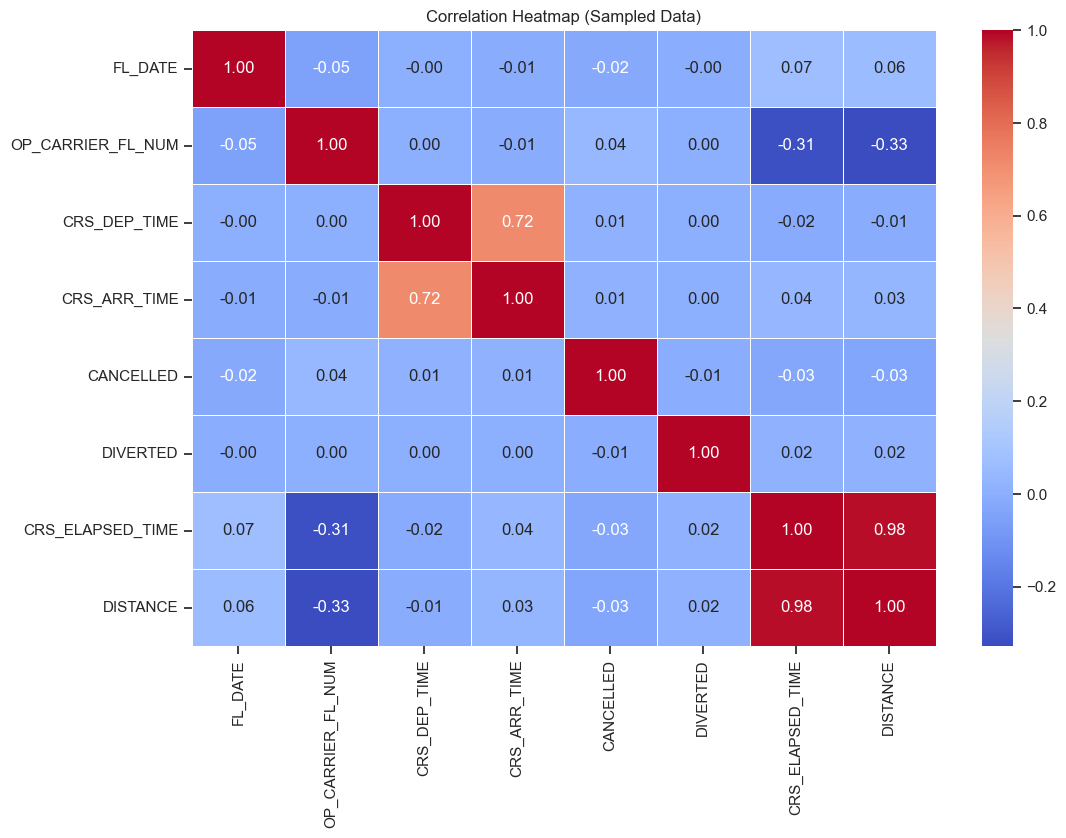

In [70]:
sample_df = classify_df.sample(fraction=0.01, seed=42)  # Hanya 1% data
dataset = sample_df.toPandas()

plt.figure(figsize=(12, 8))
korelasi = dataset.corr(numeric_only=True)
sns.heatmap(korelasi, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap (Sampled Data)")
plt.show()

In [74]:
#Ubah kolom string menjadi numerik
# StringIndexer untuk kolom kategorikal

carrier_indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="OP_CARRIER_Index")
origin_indexer = StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_Index")
dest_indexer = StringIndexer(inputCol="DEST", outputCol="DEST_Index")

In [75]:
df_indexed = carrier_indexer.fit(df).transform(df)
df_indexed = origin_indexer.fit(df_indexed).transform(df_indexed)
df_indexed = dest_indexer.fit(df_indexed).transform(df_indexed)
df_indexed.show(truncate=False)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+----------------+------------+----------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|OP_CARRIER_Index|ORIGIN_Index|DEST_Index|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+----------------

In [76]:
onehotencoder_carrier_vector = OneHotEncoder(inputCol="OP_CARRIER_Index", outputCol="OP_CARRIER_vec")
onehotencoder_origin_vector = OneHotEncoder(inputCol="ORIGIN_Index", outputCol="ORIGIN_vec")
onehotencoder_dest_vector = OneHotEncoder(inputCol="DEST_Index", outputCol="DEST_vec")

In [77]:
pipeline = Pipeline(stages=[carrier_indexer, origin_indexer, dest_indexer,
                            onehotencoder_carrier_vector, onehotencoder_origin_vector,
                            onehotencoder_dest_vector])

transformed_df = pipeline.fit(classify_df).transform(classify_df)

In [78]:
#transformed_df = transformed_df.withColumn("FL_DATE", F.unix_timestamp("FL_DATE"))
transformed_df.show(5, truncate=False)


+----------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+----------------+------------+----------+---------------+----------------+----------------+
|FL_DATE   |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|DISTANCE|OP_CARRIER_Index|ORIGIN_Index|DEST_Index|OP_CARRIER_vec |ORIGIN_vec      |DEST_vec        |
+----------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+----------------+------------+----------+---------------+----------------+----------------+
|1356973200|VX        |108              |LAX   |IAD |700.0       |1445.0      |0.0      |0.0     |285.0           |2288.0  |13.0            |4.0         |33.0      |(16,[13],[1.0])|(347,[4],[1.0]) |(342,[33],[1.0])|
|1356973200|VX        |114              |LAX   |IAD |2205.0      |545.0       |0.0      |0.0     |280.0           |2288.0  |13.0        

In [79]:
feature_columns = transformed_df.columns

# remove cols that whould not be in our feature cols (label col, intermediate preprocessing cols)
for item in ["CANCELLED", "ORIGIN", "DEST", "OP_CARRIER", "OP_CARRIER_Index", "ORIGIN_Index", "DEST_Index"]:
    feature_columns.remove(item)


assembler = VectorAssembler(inputCols=feature_columns, outputCol="features",handleInvalid="skip")

# build feature col
assembled_df = assembler.transform(transformed_df)

In [80]:

assembled_df.show(5, truncate=False)

+----------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+----------------+------------+----------+---------------+----------------+----------------+----------------------------------------------------------------------------------------+
|FL_DATE   |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|DISTANCE|OP_CARRIER_Index|ORIGIN_Index|DEST_Index|OP_CARRIER_vec |ORIGIN_vec      |DEST_vec        |features                                                                                |
+----------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+----------------+------------+----------+---------------+----------------+----------------+----------------------------------------------------------------------------------------+
|1356973200|VX        |108              |LAX   |IAD |700.0       |1445.0      |0.0   

In [81]:
final_classify_df = assembled_df.select("features", F.col("CANCELLED").alias("label"))

In [82]:
final_classify_df.dropna()



DataFrame[features: vector, label: double]

In [83]:
#Count null values in each column
null_counts = final_classify_df.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in final_classify_df.columns])
null_counts.show()

+--------+-----+
|features|label|
+--------+-----+
|       0|    0|
+--------+-----+



In [84]:
final_classify_df.printSchema()
final_classify_df.filter(F.col("label") == 1.0).show()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
|(712,[0,1,2,3,5,6...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [85]:
train, test = final_classify_df.randomSplit([.8, .2], seed=9)

In [86]:
train = train.repartition(8).cache()
test = test.repartition(8).cache()

In [87]:
test.show(5)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(712,[0,1,2,3,5,6...|  0.0|
|(712,[0,1,2,3,5,6...|  0.0|
|(712,[0,1,2,3,5,6...|  0.0|
|(712,[0,1,2,3,5,6...|  0.0|
|(712,[0,1,2,3,5,6...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [88]:
train.show(5,truncate=False)

+----------------------------------------------------------------------------------------+-----+
|features                                                                                |label|
+----------------------------------------------------------------------------------------+-----+
|(712,[0,1,2,3,5,6,9,26,372],[1.3573188E9,1238.0,1610.0,1905.0,115.0,641.0,1.0,1.0,1.0]) |0.0  |
|(712,[0,1,2,3,5,6,7,51,397],[1.3608612E9,24.0,1200.0,1300.0,60.0,239.0,1.0,1.0,1.0])    |0.0  |
|(712,[0,1,2,3,5,6,9,47,375],[1.3615524E9,1783.0,2025.0,2350.0,385.0,2585.0,1.0,1.0,1.0])|0.0  |
|(712,[0,1,2,3,5,6,7,94,378],[1.358874E9,1097.0,1205.0,1245.0,100.0,519.0,1.0,1.0,1.0])  |0.0  |
|(712,[0,1,2,3,5,6,16,52,393],[1.3591332E9,764.0,930.0,1735.0,305.0,2350.0,1.0,1.0,1.0]) |0.0  |
+----------------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [89]:
log_regress = LogisticRegression(labelCol = 'label', featuresCol = 'features')
decision_tree = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features')

In [90]:
log_regress_model = log_regress.fit(train)

In [91]:
decision_tree_model = decision_tree.fit(train)

In [92]:
log_regress_predictions = log_regress_model.transform(test)
decision_tree_predictions = decision_tree_model.transform(test)

In [93]:
evaluator_Acc = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
evaluator_F1 = MulticlassClassificationEvaluator(labelCol='label', metricName='f1')

In [94]:
# find train accuracy
train_accuracy = evaluator_Acc.evaluate(log_regress_model.transform(train))
print("Train Accuracy: ", train_accuracy)
# find train accuracy
train_f1 = evaluator_F1.evaluate(log_regress_model.transform(train))
print("Train F1: ", train_f1)


Train Accuracy:  0.9842618310599834
Train F1:  0.9764552028854466


In [95]:
# find train accuracy
train_accuracy = evaluator_Acc.evaluate(decision_tree_model.transform(train))
print("Train Accuracy: ", train_accuracy)
train_f1 = evaluator_F1.evaluate(decision_tree_model.transform(train))
print("Train F1: ", train_f1)

Train Accuracy:  0.9842617883954757
Train F1:  0.9764550965614605


In [96]:
log_regress_Acc = evaluator_Acc.evaluate(log_regress_predictions)
decision_tree_Acc = evaluator_Acc.evaluate(decision_tree_predictions)
log_regress_F1 = evaluator_F1.evaluate(log_regress_predictions)
decision_tree_F1 = evaluator_F1.evaluate(decision_tree_predictions)

In [97]:
# Menghitung jumlah nilai 0 dan 1 pada kolom prediction
prediction_counts = decision_tree_predictions.groupBy("prediction").count()
label_counts = decision_tree_predictions.groupBy("label").count()

# Menampilkan hasil
prediction_counts.show(10, truncate=False)
label_counts.show(10, truncate=False)


+----------+-------+
|prediction|count  |
+----------+-------+
|0.0       |5861935|
+----------+-------+

+-----+-------+
|label|count  |
+-----+-------+
|0.0  |5769409|
|1.0  |92526  |
+-----+-------+



In [98]:
# Menampilkan hanya prediksi dengan nilai 0.0 (false)
false_predictions = log_regress_predictions.filter(log_regress_predictions.prediction == 1.0)

# Menampilkan hasil filter
false_predictions.select("prediction", "label", "features").show(20, truncate=False)


+----------+-----+---------------------------------------------------------------------------------------+
|prediction|label|features                                                                               |
+----------+-----+---------------------------------------------------------------------------------------+
|1.0       |1.0  |(712,[0,1,2,3,5,6,10,73,377],[1.4486436E9,2360.0,700.0,1545.0,585.0,956.0,1.0,1.0,1.0])|
+----------+-----+---------------------------------------------------------------------------------------+



In [99]:
print("Logistic Regression PR:", log_regress_Acc)
print("Logistic Regression F1:", log_regress_F1)
print("Decision Tree PR:", decision_tree_Acc)
print("Decision Tree F1:", decision_tree_F1)

Logistic Regression PR: 0.9842159628177385
Logistic Regression F1: 0.9763868942395922
Decision Tree PR: 0.9842157922256047
Decision Tree F1: 0.976386469114581


In [ ]:
log_regress_confusion = log_regress_predictions.crosstab("label", "prediction")
print("Confusion Matrix for Logistic Regression:")
log_regress_confusion.show()

# Confusion Matrix untuk Decision Tree
decision_tree_confusion = decision_tree_predictions.crosstab("label", "prediction")
print("Confusion Matrix for Decision Tree:")
decision_tree_confusion.show()

Confusion Matrix for Logistic Regression:
+----------------+-------+---+
|label_prediction|    0.0|1.0|
+----------------+-------+---+
|             1.0|  92525|  1|
|             0.0|5769409|  0|
+----------------+-------+---+



In [100]:
#Balanced the dataset 0 and 1

# Count how many examples are in each class
counts = final_classify_df.groupBy("label").count().toPandas()
print(counts)

# Filter the minority and majority classes
ones = final_classify_df.filter(F.col("label") == 1.0)
zeros = final_classify_df.filter(F.col("label") == 0.0)

# Get counts for each class
ones_count = ones.count()
zeros_count = zeros.count()

# Calculate the fraction to sample from zeros
fraction = ones_count / zeros_count if zeros_count else 0

# Sample zeros to match ones count
zeros_sampled = zeros.sample(withReplacement=False, fraction=fraction, seed=42)

# Combine the two DataFrames to get a balanced dataset
balanced_df = ones.union(zeros_sampled)
print("Balanced dataset count:", balanced_df.count())


   label     count
0    0.0  28839212
1    1.0    461409
Balanced dataset count: 923607


In [101]:
count_df = balanced_df.groupBy("label").count()
count_df.show(10, truncate=False)

+-----+------+
|label|count |
+-----+------+
|1.0  |461409|
|0.0  |462198|
+-----+------+



In [102]:
train, test = balanced_df.randomSplit([.8, .2], seed=9)

In [103]:
train = train.repartition(8).cache()
test = test.repartition(8).cache()

In [104]:
balanced_log_regress = LogisticRegression(labelCol = 'label', featuresCol = 'features')
balanced_decision_tree = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features')

In [105]:
balanced_log_regress_model = balanced_log_regress.fit(train)

In [106]:
balanced_decision_tree_model = balanced_decision_tree.fit(train)

In [107]:
train_accuracy = evaluator_Acc.evaluate(balanced_log_regress_model.transform(train))
print("Train Accuracy: ", train_accuracy)
train_f1 = evaluator_F1.evaluate(balanced_log_regress_model.transform(train))
print("Train F1: ", train_f1)

Train Accuracy:  0.6553512717467957
Train F1:  0.6553277222150532


In [108]:
train_accuracy = evaluator_Acc.evaluate(balanced_decision_tree_model.transform(train))
print("Train Accuracy: ", train_accuracy)
train_f1 = evaluator_F1.evaluate(balanced_decision_tree_model.transform(train))
print("Train F1: ", train_f1)

Train Accuracy:  0.614417958085348
Train F1:  0.6029578685941204


In [109]:
balanced_log_regress_predictions = balanced_log_regress_model.transform(test)
balanced_decision_tree_predictions = balanced_decision_tree_model.transform(test)

In [110]:
count_val = balanced_log_regress_predictions.groupBy("prediction").count()
count_val.show(10, truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0.0       |93854|
|1.0       |90966|
+----------+-----+



In [111]:
balanced_log_regress_predictions.select("prediction", "label", "features").show(10, truncate=False)

+----------+-----+---------------------------------------------------------------------------------------+
|prediction|label|features                                                                               |
+----------+-----+---------------------------------------------------------------------------------------+
|0.0       |1.0  |(712,[0,1,2,3,5,6,10,34,399],[1.3587012E9,5433.0,2107.0,2155.0,48.0,129.0,1.0,1.0,1.0])|
|1.0       |1.0  |(712,[0,1,2,3,5,6,9,40,372],[1.3580964E9,721.0,920.0,1245.0,265.0,1389.0,1.0,1.0,1.0]) |
|1.0       |1.0  |(712,[0,1,2,3,5,6,11,83,406],[1.3613796E9,5118.0,1400.0,1532.0,92.0,393.0,1.0,1.0,1.0])|
|0.0       |1.0  |(712,[0,1,2,3,5,6,7,90,378],[1.3580964E9,1792.0,755.0,840.0,105.0,583.0,1.0,1.0,1.0])  |
|0.0       |1.0  |(712,[0,1,2,3,5,6,22,23,455],[1.3613796E9,57.0,1435.0,1559.0,144.0,782.0,1.0,1.0,1.0]) |
|1.0       |1.0  |(712,[0,1,2,3,5,6,11,91,371],[1.359306E9,6064.0,604.0,730.0,146.0,760.0,1.0,1.0,1.0])  |
|1.0       |1.0  |(712,[0,1,2,3,5,6,7

In [112]:
# Menghitung True Positives (TP) dan True Negatives (TN)
correct_predictions = balanced_log_regress_predictions.filter((balanced_log_regress_predictions.prediction == balanced_log_regress_predictions.label))


correct_count = correct_predictions.count()


print(f"Jumlah prediksi yang benar: {correct_count}")


correct_predictions.show(10, truncate=False)


Jumlah prediksi yang benar: 120826
+-----------------------------------------------------------------------------------------+-----+--------------------------------------------+----------------------------------------+----------+
|features                                                                                 |label|rawPrediction                               |probability                             |prediction|
+-----------------------------------------------------------------------------------------+-----+--------------------------------------------+----------------------------------------+----------+
|(712,[0,1,2,3,5,6,9,40,372],[1.3580964E9,721.0,920.0,1245.0,265.0,1389.0,1.0,1.0,1.0])   |1.0  |[-0.9730998268423708,0.9730998268423708]    |[0.2742630723242524,0.7257369276757476] |1.0       |
|(712,[0,1,2,3,5,6,11,83,406],[1.3613796E9,5118.0,1400.0,1532.0,92.0,393.0,1.0,1.0,1.0])  |1.0  |[-0.44598608056365063,0.44598608056365063]  |[0.3903155340888267,0.6096844659111733] |1.

In [113]:
balanced_log_regress_Acc = evaluator_Acc.evaluate(balanced_log_regress_predictions)
balanced_decision_tree_Acc = evaluator_Acc.evaluate(balanced_decision_tree_predictions)
balanced_log_regress_F1 = evaluator_F1.evaluate(balanced_log_regress_predictions)
balanced_decision_tree_F1 = evaluator_F1.evaluate(balanced_decision_tree_predictions)

In [114]:
print("Logistic Regression PR:", balanced_log_regress_Acc)
print("Logistic Regression F1:", balanced_log_regress_F1)
print("Decision Tree PR:", balanced_decision_tree_Acc)
print("Decision Tree F1:", balanced_decision_tree_F1)

Logistic Regression PR: 0.653749594199762
Logistic Regression F1: 0.6537285542437341
Decision Tree PR: 0.6127096634563359
Decision Tree F1: 0.6014983024344396


In [125]:
log_regress_confusion_bl = balanced_log_regress_predictions.crosstab("label", "prediction")
print("Confusion Matrix for Logistic Regression:")
log_regress_confusion.show()

# Confusion Matrix untuk Decision Tree
decision_tree_confusion_bl = balanced_decision_tree_predictions.crosstab("label", "prediction")
print("Confusion Matrix for Decision Tree:")
decision_tree_confusion.show()

Confusion Matrix for Logistic Regression:
+----------------+-----+-----+
|label_prediction|  0.0|  1.0|
+----------------+-----+-----+
|             1.0|33064|59444|
|             0.0|61192|31120|
+----------------+-----+-----+

Confusion Matrix for Decision Tree:
+----------------+-----+-----+
|label_prediction|  0.0|  1.0|
+----------------+-----+-----+
|             1.0|32777|59731|
|             0.0|64951|27361|
+----------------+-----+-----+



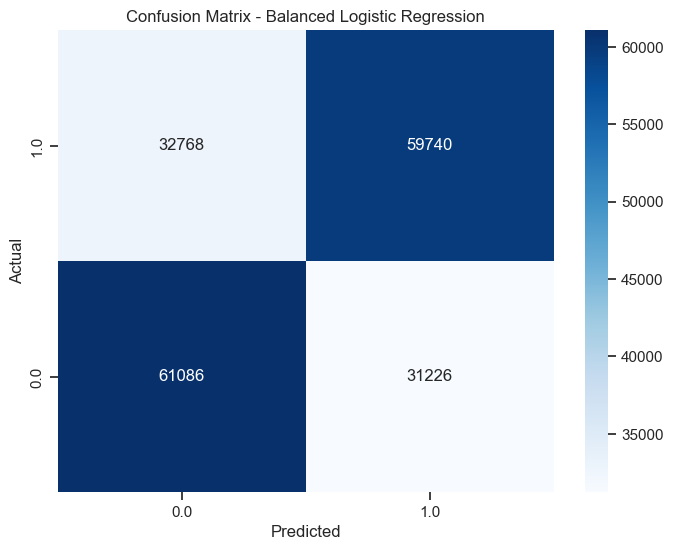

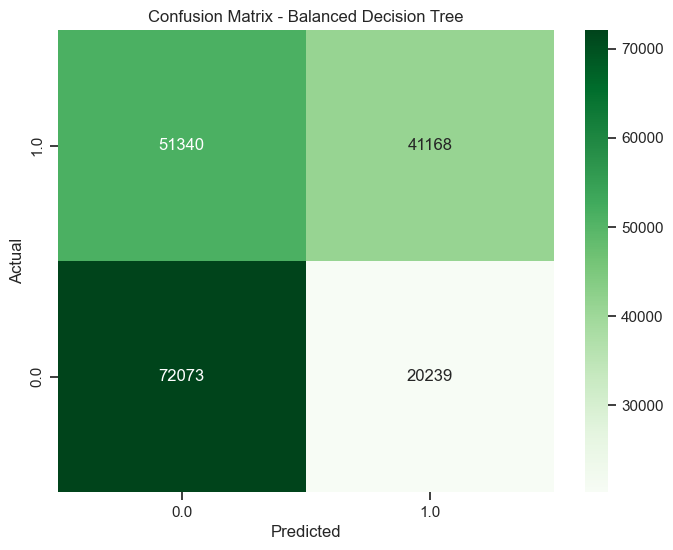

In [127]:
# ==== LOGISTIC REGRESSION ====
log_regress_confusion_pd = log_regress_confusion_bl.toPandas()

# Atur index dan ubah ke integer
log_regress_confusion_pd.set_index("label_prediction", inplace=True)
log_regress_confusion_pd.index.name = "Actual"
log_regress_confusion_pd.columns.name = "Predicted"
log_regress_confusion_pd = log_regress_confusion_pd.astype(int)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_regress_confusion_pd, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Balanced Logistic Regression")
plt.show()


# ==== DECISION TREE ====
decision_tree_confusion_pd = decision_tree_confusion_bl.toPandas()

decision_tree_confusion_pd.set_index("label_prediction", inplace=True)
decision_tree_confusion_pd.index.name = "Actual"
decision_tree_confusion_pd.columns.name = "Predicted"
decision_tree_confusion_pd = decision_tree_confusion_pd.astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(decision_tree_confusion_pd, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Balanced Decision Tree")
plt.show()

In [117]:
#Hyperparameter tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(log_regress.regParam, [0.01, 0.1, 0.5])
             .addGrid(log_regress.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(log_regress.maxIter, [10, 20,30])
             .build())

paramGrid_dt = (ParamGridBuilder()
             .addGrid(decision_tree.maxDepth, [2, 5, 10])
             .addGrid(decision_tree.maxBins, [20, 40, 80])
             .build())

crossval = CrossValidator(estimator=log_regress,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator_Acc,
                            numFolds=5)  # 5-fold cross-validation

crossval_dt = CrossValidator(estimator=decision_tree,
                            estimatorParamMaps=paramGrid_dt,
                            evaluator=evaluator_Acc,
                            numFolds=5)  # 5-fold cross-validation

In [118]:
cvModel = crossval.fit(train)
best_model = cvModel.bestModel

predictions_lr = best_model.transform(test)
best_accuracy = evaluator_Acc.evaluate(predictions_lr)
best_f1 = evaluator_F1.evaluate(predictions_lr)

In [119]:
print("Best Logistic Regression Model Accuracy:", best_accuracy)
print("Best Logistic Regression Model F1 Score:", best_f1)

Best Logistic Regression Model Accuracy: 0.652721566929986
Best Logistic Regression Model F1 Score: 0.6526870162642342


In [120]:
cvModel = crossval_dt.fit(train)
best_model_dt = cvModel.bestModel
predictions_dt = best_model_dt.transform(test)
best_accuracy_dt = evaluator_Acc.evaluate(predictions_dt)
best_f1_dt = evaluator_F1.evaluate(predictions_dt)
print("Best Decision Tree Model Accuracy:", best_accuracy_dt)
print("Best Decision Tree Model F1 Score:", best_f1_dt)

Best Decision Tree Model Accuracy: 0.6746131371063737
Best Decision Tree Model F1 Score: 0.6743436128729914


In [122]:
log_regress_confusion = predictions_lr.crosstab("label", "prediction")
print("Confusion Matrix for Logistic Regression:")
log_regress_confusion.show()

# Confusion Matrix untuk Decision Tree
decision_tree_confusion = predictions_dt.crosstab("label", "prediction")
print("Confusion Matrix for Decision Tree:")
decision_tree_confusion.show()

Confusion Matrix for Logistic Regression:
+----------------+-----+-----+
|label_prediction|  0.0|  1.0|
+----------------+-----+-----+
|             1.0|33064|59444|
|             0.0|61192|31120|
+----------------+-----+-----+

Confusion Matrix for Decision Tree:
+----------------+-----+-----+
|label_prediction|  0.0|  1.0|
+----------------+-----+-----+
|             1.0|32777|59731|
|             0.0|64951|27361|
+----------------+-----+-----+



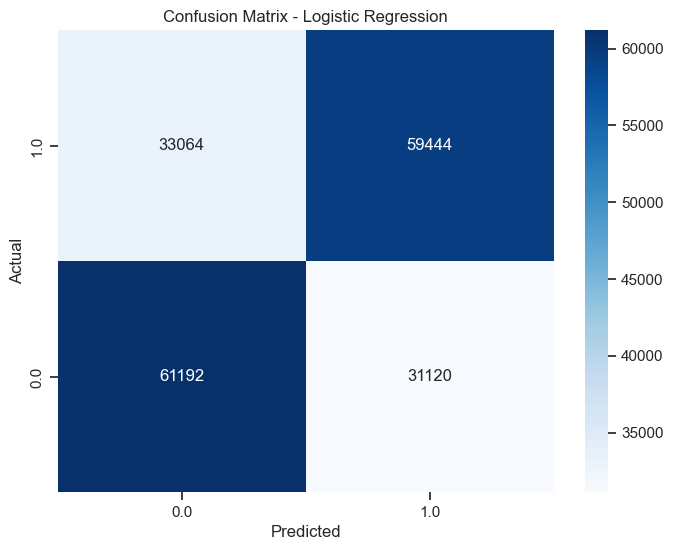

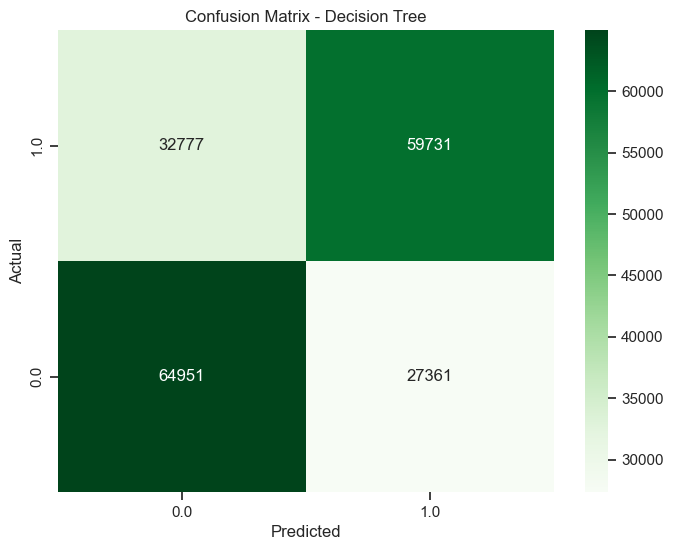

In [124]:

# Confusion Matrix untuk Logistic Regression
log_regress_confusion = predictions_lr.crosstab("label", "prediction")
log_regress_confusion_pd = log_regress_confusion.toPandas()
log_regress_confusion_pd.set_index('label_prediction', inplace=True)
log_regress_confusion_pd.columns.name = 'Predicted'
log_regress_confusion_pd.index.name = 'Actual'
log_regress_confusion_pd = log_regress_confusion_pd.astype(int)

# Plot confusion matrix untuk Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(log_regress_confusion_pd, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# Confusion Matrix untuk Decision Tree
decision_tree_confusion = predictions_dt.crosstab("label", "prediction")
decision_tree_confusion_pd = decision_tree_confusion.toPandas()
decision_tree_confusion_pd.set_index('label_prediction', inplace=True)
decision_tree_confusion_pd.columns.name = 'Predicted'
decision_tree_confusion_pd.index.name = 'Actual'
decision_tree_confusion_pd = decision_tree_confusion_pd.astype(int)

# Plot confusion matrix untuk Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(decision_tree_confusion_pd, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Decision Tree")
plt.show()